In [30]:
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryConfusionMatrix

import numpy as np
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence

import contractions

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load dataset

In [32]:
dataset = load_dataset("imdb", cache_dir='./data')
dataset

Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at data\imdb\plain_text\0.0.0\e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jul 28 19:25:48 2025).


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Preprocessing

In [33]:
split_Dataset = dataset['train'].train_test_split(test_size=0.2, shuffle=True)

train = split_Dataset['train']
val = split_Dataset['test']
test = dataset['test']

In [34]:
X_train, y_train = train['text'], train['label']
X_val, y_val = val['text'], val['label']
X_test, y_test = test['text'], test['label']

#### Remove html scripts, square brackets & special character

In [35]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def clean_text(text):
    text = contractions.fix(text)
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    return text

In [36]:
X_train = [clean_text(text) for text in X_train]
X_val   = [clean_text(text) for text in X_val]
X_test  = [clean_text(text) for text in X_test]

### Tokenize

In [37]:
X_train_tokenized = [[token for token in word_tokenize(text.lower())] for text in X_train]
X_val_tokenized = [[token for token in word_tokenize(text.lower())] for text in X_val]
X_test_tokenized = [[token for token in word_tokenize(text.lower())] for text in X_test]

In [38]:
print(X_train[0])
print(X_train_tokenized[0])

To be honest I watched this movie only because of my pubert needs I mean I could not get women at my age I was 9 or 10 so I thought watching Elviras cleavage was the closet thing to sexI ended up having a great time with this cult classic about horror comedy Halloween parties sassy humor and some sexy evil displayed by ElviraThey just do not make movies like this anymore It had the feeling of an amateur effort mixed with a late night cable talk show host style The truth is that it generated plenty of fans because of it is humor and the ability to perform by Cassandra This is classic that reminds me of the good days of USA Up All Night
['to', 'be', 'honest', 'i', 'watched', 'this', 'movie', 'only', 'because', 'of', 'my', 'pubert', 'needs', 'i', 'mean', 'i', 'could', 'not', 'get', 'women', 'at', 'my', 'age', 'i', 'was', '9', 'or', '10', 'so', 'i', 'thought', 'watching', 'elviras', 'cleavage', 'was', 'the', 'closet', 'thing', 'to', 'sexi', 'ended', 'up', 'having', 'a', 'great', 'time', 'w

### Delete stopwords

In [39]:
stopword_list = stopwords.words('english')
print(stopword_list)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [40]:
X_train_cleaned = [[token for token in text if token not in stopword_list]for text in X_train_tokenized]
X_val_cleaned = [[token for token in text if token not in stopword_list]for text in X_val_tokenized]
X_test_cleaned = [[token for token in text if token not in stopword_list]for text in X_test_tokenized]

In [41]:
print(X_train[0])
print(X_train_cleaned[0])

To be honest I watched this movie only because of my pubert needs I mean I could not get women at my age I was 9 or 10 so I thought watching Elviras cleavage was the closet thing to sexI ended up having a great time with this cult classic about horror comedy Halloween parties sassy humor and some sexy evil displayed by ElviraThey just do not make movies like this anymore It had the feeling of an amateur effort mixed with a late night cable talk show host style The truth is that it generated plenty of fans because of it is humor and the ability to perform by Cassandra This is classic that reminds me of the good days of USA Up All Night
['honest', 'watched', 'movie', 'pubert', 'needs', 'mean', 'could', 'get', 'women', 'age', '9', '10', 'thought', 'watching', 'elviras', 'cleavage', 'closet', 'thing', 'sexi', 'ended', 'great', 'time', 'cult', 'classic', 'horror', 'comedy', 'halloween', 'parties', 'sassy', 'humor', 'sexy', 'evil', 'displayed', 'elvirathey', 'make', 'movies', 'like', 'anymor

### Lemmatize 

In [42]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag) :
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [43]:
X_train_lemmatized = [[lemmatizer.lemmatize(token, get_wordnet_pos(pos))for token, pos in pos_tag(text)]for text in X_train_cleaned]
X_val_lemmatized = [[lemmatizer.lemmatize(token, get_wordnet_pos(pos))for token, pos in pos_tag(text)]for text in X_val_cleaned]
X_test_lemmatized = [[lemmatizer.lemmatize(token, get_wordnet_pos(pos))for token, pos in pos_tag(text)]for text in X_test_cleaned]

In [44]:
print(X_train[0])
print(X_train_lemmatized[0])

To be honest I watched this movie only because of my pubert needs I mean I could not get women at my age I was 9 or 10 so I thought watching Elviras cleavage was the closet thing to sexI ended up having a great time with this cult classic about horror comedy Halloween parties sassy humor and some sexy evil displayed by ElviraThey just do not make movies like this anymore It had the feeling of an amateur effort mixed with a late night cable talk show host style The truth is that it generated plenty of fans because of it is humor and the ability to perform by Cassandra This is classic that reminds me of the good days of USA Up All Night
['honest', 'watched', 'movie', 'pubert', 'need', 'mean', 'could', 'get', 'woman', 'age', '9', '10', 'thought', 'watch', 'elviras', 'cleavage', 'closet', 'thing', 'sexi', 'end', 'great', 'time', 'cult', 'classic', 'horror', 'comedy', 'halloween', 'party', 'sassy', 'humor', 'sexy', 'evil', 'display', 'elvirathey', 'make', 'movie', 'like', 'anymore', 'feel',

In [45]:
X_train_str = [' '.join(tokens) for tokens in X_train_lemmatized]
X_val_str = [' '.join(tokens) for tokens in X_val_lemmatized]
X_test_str = [' '.join(tokens) for tokens in X_test_lemmatized]

In [46]:
X_train_str[0]

'honest watched movie pubert need mean could get woman age 9 10 thought watch elviras cleavage closet thing sexi end great time cult classic horror comedy halloween party sassy humor sexy evil display elvirathey make movie like anymore feel amateur effort mixed late night cable talk show host style truth generate plenty fan humor ability perform cassandra classic remind good day usa night'

### TFidf

In [75]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train_str)
X_val_tfidf = vectorizer.transform(X_val_str)
X_test_tfidf = vectorizer.transform(X_test_str)

#### Convert to tensor

In [76]:
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_tfidf.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Dataloader

In [77]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

#### MLP model

In [89]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

In [165]:
model_tfidf = MLP(input_dim=5000).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model_tfidf.parameters(), lr=0.00005, weight_decay=0.01)
scheduler_tfidf = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

### train model

In [166]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

In [167]:
best_f1 = 0
patience = 3
counter = 0

epochs = 30

for epoch in range(epochs):
    model_tfidf.train()
    total_loss = 0

    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Training]', leave=False)
    for text, label in train_loop:
        text, label = text.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = model_tfidf(text)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    model_tfidf.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        for text, label in val_loop:
            text, label = text.to(device), label.to(device)

            outputs = model_tfidf(text)
            loss = criterion(outputs, label)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            accuracy_metric.update(preds, label)
            f1_metric.update(preds, label)

            val_loop.set_postfix(loss=loss.item())
    val_acc = accuracy_metric.compute().item()
    val_f1 = f1_metric.compute().item()

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        counter = 0
        torch.save(model_tfidf.state_dict(), "./models/tfidf.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    scheduler_tfidf.step()

[Epoch 1] Train Loss: 354.1142 || Val Loss: 69.3808 | Acc: 0.8440 | F1: 0.8475


[Epoch 2] Train Loss: 250.8586 || Val Loss: 57.0997 | Acc: 0.8632 | F1: 0.8675


[Epoch 3] Train Loss: 212.1585 || Val Loss: 54.0075 | Acc: 0.8700 | F1: 0.8706


[Epoch 4] Train Loss: 193.6552 || Val Loss: 51.8676 | Acc: 0.8718 | F1: 0.8722


[Epoch 5] Train Loss: 178.7542 || Val Loss: 50.2243 | Acc: 0.8724 | F1: 0.8730


[Epoch 6] Train Loss: 170.2556 || Val Loss: 49.5147 | Acc: 0.8752 | F1: 0.8788


[Epoch 7] Train Loss: 164.2856 || Val Loss: 49.0781 | Acc: 0.8750 | F1: 0.8773


[Epoch 8] Train Loss: 161.9724 || Val Loss: 48.9501 | Acc: 0.8754 | F1: 0.8779


[Epoch 9] Train Loss: 159.7796 || Val Loss: 48.2916 | Acc: 0.8756 | F1: 0.8784
Early stopping triggered.


In [168]:
model_tfidf.load_state_dict(torch.load('./models/tfidf.pth'))

<All keys matched successfully>

### Test

In [169]:
def create_heatmap(confusion_matrix) :
    plt.figure(figsize=(12, 7))
    sns.heatmap(confusion_matrix.compute().to('cpu'),
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                linewidths=0.5, 
                square=True, 
                cbar_kws={"shrink": 0.75},

    )


    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

test F1 : 0.8747352957725525
test acc : 0.8722400069236755


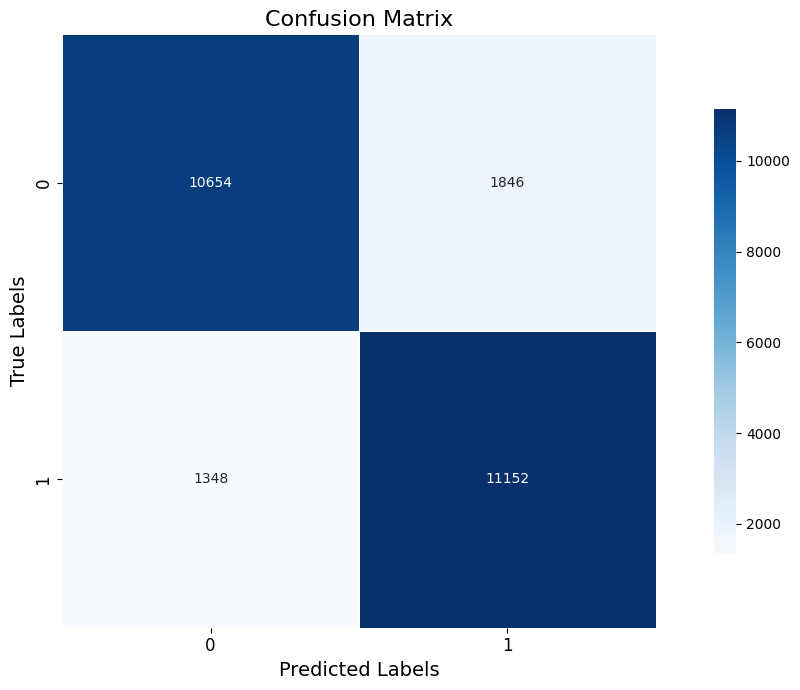

In [170]:
accuracy_metric_test = BinaryAccuracy().to(device)
f1_metric_test = BinaryF1Score().to(device)
CF = BinaryConfusionMatrix().to(device)

model_tfidf.eval()
with torch.no_grad() :
    for text, label in test_loader:
        text, label = text.to(device), label.to(device)
        outputs = model_tfidf(text)
        loss = criterion(outputs, label)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        accuracy_metric_test.update(preds, label)
        f1_metric_test.update(preds, label)
        CF.update(preds, label)

print(f"test F1 : {f1_metric_test.compute().item()}\ntest acc : {accuracy_metric_test.compute().item()}" )
create_heatmap(CF)

### BagofWords

In [171]:
vectorizer_BOW = CountVectorizer(max_features=5000)

X_train_BOW = vectorizer_BOW.fit_transform(X_train_str)
X_val_BOW = vectorizer_BOW.transform(X_val_str)
X_test_BOW = vectorizer_BOW.transform(X_test_str)

#### Convert to tensor

In [172]:
X_train_tensor = torch.tensor(X_train_BOW.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_BOW.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_BOW.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Dataloader

In [173]:
train_dataset_BOW = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_BOW = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_BOW = TensorDataset(X_test_tensor, y_test_tensor)

train_loader_BOW = DataLoader(train_dataset_BOW, batch_size=32, shuffle=True)
val_loader_BOW = DataLoader(val_dataset_BOW, batch_size=32)
test_loader_BOW = DataLoader(test_dataset_BOW, batch_size=32)

### Train

In [178]:
model_BOW = MLP(input_dim=5000).to(device)

criterion_BOW = nn.BCEWithLogitsLoss()
optimizer_BOW = optim.AdamW(model_BOW.parameters(), lr=0.00005, weight_decay=0.01)
scheduler_BOW = optim.lr_scheduler.StepLR(optimizer_BOW, step_size=2, gamma=0.5)

In [179]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 3
counter = 0

epochs = 30

for epoch in range(epochs):
    model_BOW.train()
    total_loss = 0

    train_loop = tqdm(train_loader_BOW, desc=f'Epoch {epoch+1}/{epochs} [Training]', leave=False)
    for text, label in train_loop:
        text, label = text.to(device), label.to(device)

        optimizer_BOW.zero_grad()
        outputs = model_BOW(text)
        loss = criterion_BOW(outputs, label)
        loss.backward()
        optimizer_BOW.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    model_BOW.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_loader_BOW, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        for text, label in val_loop:
            text, label = text.to(device), label.to(device)

            outputs = model_BOW(text)
            loss = criterion_BOW(outputs, label)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            accuracy_metric.update(preds, label)
            f1_metric.update(preds, label)

            val_loop.set_postfix(loss=loss.item())
    val_acc = accuracy_metric.compute().item()
    val_f1 = f1_metric.compute().item()

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        counter = 0
        torch.save(model_tfidf.state_dict(), "./models/BOW.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    scheduler_BOW.step()

[Epoch 1] Train Loss: 363.4311 || Val Loss: 73.9861 | Acc: 0.8380 | F1: 0.8392


[Epoch 2] Train Loss: 269.1328 || Val Loss: 61.9942 | Acc: 0.8598 | F1: 0.8642


[Epoch 3] Train Loss: 231.3607 || Val Loss: 57.9123 | Acc: 0.8638 | F1: 0.8669


[Epoch 4] Train Loss: 214.7285 || Val Loss: 54.9697 | Acc: 0.8684 | F1: 0.8689


[Epoch 5] Train Loss: 200.6484 || Val Loss: 53.7478 | Acc: 0.8702 | F1: 0.8697


[Epoch 6] Train Loss: 193.4575 || Val Loss: 52.1787 | Acc: 0.8706 | F1: 0.8702


[Epoch 7] Train Loss: 186.7546 || Val Loss: 52.5179 | Acc: 0.8718 | F1: 0.8702


[Epoch 8] Train Loss: 184.3595 || Val Loss: 51.7284 | Acc: 0.8720 | F1: 0.8734


[Epoch 9] Train Loss: 181.8475 || Val Loss: 51.5329 | Acc: 0.8714 | F1: 0.8731


[Epoch 10] Train Loss: 179.6248 || Val Loss: 51.5750 | Acc: 0.8726 | F1: 0.8735


[Epoch 11] Train Loss: 177.8996 || Val Loss: 51.4271 | Acc: 0.8724 | F1: 0.8706


[Epoch 12] Train Loss: 177.1381 || Val Loss: 51.3846 | Acc: 0.8708 | F1: 0.8695


[Epoch 13] Train Loss: 178.2611 || Val Loss: 50.3345 | Acc: 0.8708 | F1: 0.8727
Early stopping triggered.


In [180]:
model_BOW.load_state_dict(torch.load("./models/BOW.pth"))

<All keys matched successfully>

### Test

test F1 : 0.8685831427574158
test acc : 0.8668799996376038


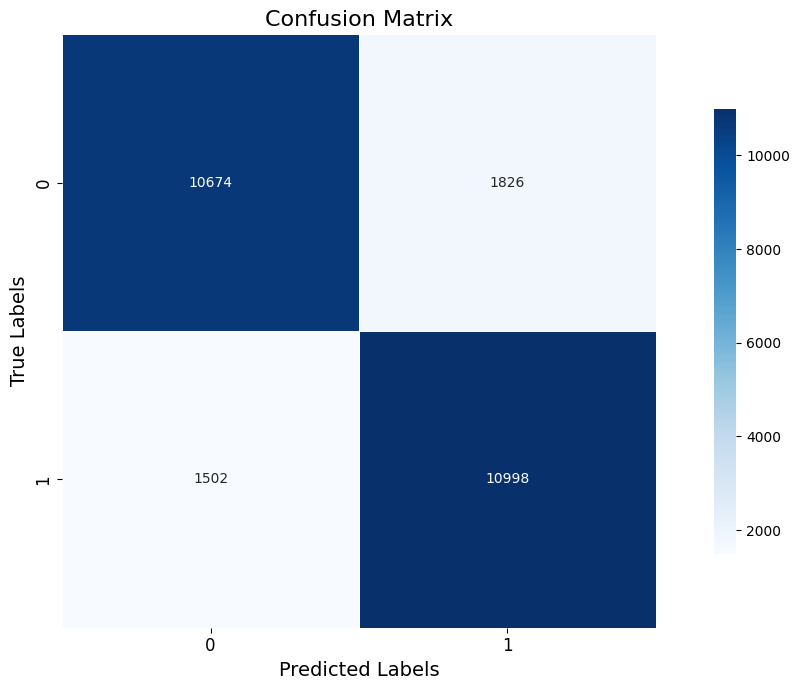

In [181]:
accuracy_metric_test = BinaryAccuracy().to(device)
f1_metric_test = BinaryF1Score().to(device)
CF = BinaryConfusionMatrix().to(device)

with torch.no_grad() :
    for text, label in test_loader_BOW:
        text, label = text.to(device), label.to(device)

        outputs = model_BOW(text)
        loss = criterion_BOW(outputs, label)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        accuracy_metric_test.update(preds, label)
        f1_metric_test.update(preds, label)
        CF.update(preds, label)

print(f"test F1 : {f1_metric_test.compute().item()}\ntest acc : {accuracy_metric_test.compute().item()}" )
create_heatmap(CF)

### GLoVe

#### Load

In [182]:
glove_path = "./data/GLoVe/glove.6B.100d.txt"
glove_cache = './glove/glove_cache.npy'
embedding_dim = 100

word2vec = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

#### Vocab and embedding

In [183]:
word2idx = {"<PAD>": 0, "<UNK>": 1}
idx = 2
for tokens in X_train_lemmatized:
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

In [184]:
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in word2idx.items():
    vec = word2vec.get(word)
    if vec is not None:
        embedding_matrix[i] = vec
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [185]:
X_train_indices = [[word2idx.get(word, word2idx["<UNK>"]) for word in review] for review in X_train_lemmatized ]
X_val_indices = [[word2idx.get(word, word2idx["<UNK>"]) for word in review] for review in X_val_lemmatized ]
X_test_indices = [[word2idx.get(word, word2idx["<UNK>"]) for word in review] for review in X_test_lemmatized ]

#### pad sequences

In [186]:
X_train_tensor = pad_sequence(
    [torch.tensor(seq) for seq in X_train_indices],
    batch_first=True,
    padding_value=word2idx["<PAD>"]
)

X_val_tensor = pad_sequence(
    [torch.tensor(seq) for seq in X_val_indices],
    batch_first=True,
    padding_value=word2idx["<PAD>"]
)

X_test_tensor = pad_sequence(
    [torch.tensor(seq) for seq in X_test_indices],
    batch_first=True,
    padding_value=word2idx["<PAD>"]
)

### Dataloader

In [187]:
train_dataset_G = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_G = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_G = TensorDataset(X_test_tensor, y_test_tensor)

train_loader_G = DataLoader(train_dataset_G, batch_size=32, shuffle=True)
val_loader_G = DataLoader(val_dataset_G, batch_size=32)
test_loader_G = DataLoader(test_dataset_G, batch_size=32)

### Model

In [302]:
class Text_classifier(nn.Module) :
    def __init__(self, embedding_matrix):
        super().__init__()
        _ , embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.FC = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        avg_emb = embedded.mean(dim=1)
        return self.FC(avg_emb).squeeze()

In [303]:
model_GLove = Text_classifier(embedding_matrix).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_GLoVe = optim.AdamW(model_GLove.parameters(), lr=0.002)
scheduler = optim.lr_scheduler.StepLR(optimizer_GLoVe, step_size=10, gamma=0.5)

### Training

In [304]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 4
counter = 0

for epoch in range(30):
    model_GLove.train()
    total_loss = 0

    train_loop = tqdm(train_loader_G, desc=f'Epoch {epoch+1}/{30} [Training]', leave=False)
    for text, label in train_loop:
        text, label = text.to(device), label.to(device)

        optimizer_GLoVe.zero_grad()
        outputs = model_GLove(text)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer_GLoVe.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    model_GLove.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_loader_G, desc=f"Epoch {epoch+1}/{30} [Validation]", leave=False)
        for text, label in val_loop:
            text, label = text.to(device), label.to(device)

            outputs = model_GLove(text)
            loss = criterion(outputs, label)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            accuracy_metric.update(preds, label)
            f1_metric.update(preds, label)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(model_GLove.state_dict(), "./models/GLoVe.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break

    scheduler.step()


[Epoch 1] Train Loss: 433.7786 || Val Loss: 108.8377 | Acc: 0.4998 | F1: 0.6665
Best model saved at epoch 1 with F1: 0.6665


[Epoch 2] Train Loss: 410.9266 || Val Loss: 87.1197 | Acc: 0.7882 | F1: 0.7517
Best model saved at epoch 2 with F1: 0.7517


[Epoch 3] Train Loss: 254.0092 || Val Loss: 61.1503 | Acc: 0.8288 | F1: 0.8060
Best model saved at epoch 3 with F1: 0.8060


[Epoch 4] Train Loss: 178.0206 || Val Loss: 48.5454 | Acc: 0.8778 | F1: 0.8743
Best model saved at epoch 4 with F1: 0.8743


[Epoch 5] Train Loss: 141.4392 || Val Loss: 45.5240 | Acc: 0.8804 | F1: 0.8784
Best model saved at epoch 5 with F1: 0.8784


[Epoch 6] Train Loss: 112.7597 || Val Loss: 44.0667 | Acc: 0.8848 | F1: 0.8840
Best model saved at epoch 6 with F1: 0.8840


[Epoch 7] Train Loss: 88.9803 || Val Loss: 44.9276 | Acc: 0.8864 | F1: 0.8883
Best model saved at epoch 7 with F1: 0.8883


[Epoch 8] Train Loss: 70.4663 || Val Loss: 49.6325 | Acc: 0.8778 | F1: 0.8709
No improvement for 1 epochs (patience: 4)


[Epoch 9] Train Loss: 54.9838 || Val Loss: 49.2734 | Acc: 0.8846 | F1: 0.8827
No improvement for 2 epochs (patience: 4)


[Epoch 10] Train Loss: 44.1510 || Val Loss: 54.9203 | Acc: 0.8756 | F1: 0.8701
No improvement for 3 epochs (patience: 4)


[Epoch 11] Train Loss: 29.9163 || Val Loss: 56.5339 | Acc: 0.8808 | F1: 0.8774
No improvement for 4 epochs (patience: 4)
Early stopping at epoch 11. Best F1: 0.8883


In [306]:
model_GLove.load_state_dict(torch.load("./models/GLoVe.pth"))

<All keys matched successfully>

### Test

test F1 : 0.8736972212791443
test acc : 0.8734800219535828


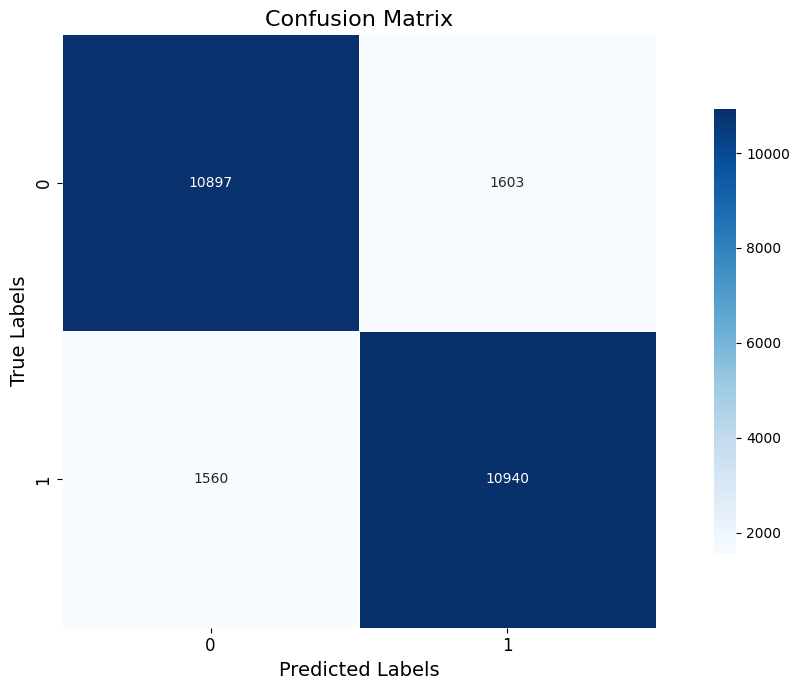

In [307]:
accuracy_metric_test = BinaryAccuracy().to(device)
f1_metric_test = BinaryF1Score().to(device)
CF = BinaryConfusionMatrix().to(device)

model_GLove.eval()
with torch.no_grad() :
    for text, label in test_loader_G:
        text, label = text.to(device), label.to(device)

        outputs = model_GLove(text)
        loss = criterion(outputs, label)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        accuracy_metric_test.update(preds, label)
        f1_metric_test.update(preds, label)
        CF.update(preds, label)

print(f"test F1 : {f1_metric_test.compute().item()}\ntest acc : {accuracy_metric_test.compute().item()}" )
create_heatmap(CF)

# 📊 Model Training Results

## **Model 1: TF-IDF**

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score |
| ----- | ---------: | -------: | -------: | -------: |
| 1     |   354.1142 |  69.3808 |   0.8440 |   0.8475 |
| 2     |   250.8586 |  57.0997 |   0.8632 |   0.8675 |
| 3     |   212.1585 |  54.0075 |   0.8700 |   0.8706 |
| 4     |   193.6552 |  51.8676 |   0.8718 |   0.8722 |
| 5     |   178.7542 |  50.2243 |   0.8724 |   0.8730 |
| 6     |   170.2556 |  49.5147 |   0.8752 |   0.8788 |
| 7     |   164.2856 |  49.0781 |   0.8750 |   0.8773 |
| 8     |   161.9724 |  48.9501 |   0.8754 |   0.8779 |
| 9     |   159.7796 |  48.2916 |   0.8756 |   0.8784 |

✅ **Early stopping triggered**
**Test F1:** `0.8747`
**Test Accuracy:** `0.8722`

---

## **Model 2: Bag of Words**

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score |
| ----- | ---------: | -------: | -------: | -------: |
| 1     |   363.4311 |  73.9861 |   0.8380 |   0.8392 |
| 2     |   269.1328 |  61.9942 |   0.8598 |   0.8642 |
| 3     |   231.3607 |  57.9123 |   0.8638 |   0.8669 |
| 4     |   214.7285 |  54.9697 |   0.8684 |   0.8689 |
| 5     |   200.6484 |  53.7478 |   0.8702 |   0.8697 |
| 6     |   193.4575 |  52.1787 |   0.8706 |   0.8702 |
| 7     |   186.7546 |  52.5179 |   0.8718 |   0.8702 |
| 8     |   184.3595 |  51.7284 |   0.8720 |   0.8734 |
| 9     |   181.8475 |  51.5329 |   0.8714 |   0.8731 |
| 10    |   179.6248 |  51.5750 |   0.8726 |   0.8735 |
| 11    |   177.8996 |  51.4271 |   0.8724 |   0.8706 |
| 12    |   177.1381 |  51.3846 |   0.8708 |   0.8695 |
| 13    |   178.2611 |  50.3345 |   0.8708 |   0.8727 |

✅ **Early stopping triggered**
**Test F1:** `0.8686`
**Test Accuracy:** `0.8669`

---

## **Model 3: GloVe**

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Note   |
| ----- | ---------: | -------: | -------: | -------: | ------ |
| 1     |   433.7786 | 108.8377 |   0.4998 |   0.6665 | ✅ Best |
| 2     |   410.9266 |  87.1197 |   0.7882 |   0.7517 | ✅ Best |
| 3     |   254.0092 |  61.1503 |   0.8288 |   0.8060 | ✅ Best |
| 4     |   178.0206 |  48.5454 |   0.8778 |   0.8743 | ✅ Best |
| 5     |   141.4392 |  45.5240 |   0.8804 |   0.8784 | ✅ Best |
| 6     |   112.7597 |  44.0667 |   0.8848 |   0.8840 | ✅ Best |
| 7     |    88.9803 |  44.9276 |   0.8864 |   0.8883 | ✅ Best |
| 8     |    70.4663 |  49.6325 |   0.8778 |   0.8709 | –      |
| 9     |    54.9838 |  49.2734 |   0.8846 |   0.8827 | –      |
| 10    |    44.1510 |  54.9203 |   0.8756 |   0.8701 | –      |
| 11    |    29.9163 |  56.5339 |   0.8808 |   0.8774 | –      |

✅ **Early stopping at epoch 11**
**Best F1:** `0.8883`
**Test F1:** `0.8737`
**Test Accuracy:** `0.8735`

---

# 🔍 **Comparison of Final Results**

| Model            | Best Epoch | Best Val F1 | Test F1 | Test Accuracy |
| ---------------- | ---------: | ----------: | ------: | ------------: |
| **TF-IDF**       |          9 |      0.8784 |  0.8747 |        0.8722 |
| **Bag of Words** |         13 |      0.8735 |  0.8686 |        0.8669 |
| **GloVe**        |          7 |      0.8883 |  0.8737 |        0.8735 |

- **Highest Validation F1:** GloVe (0.8883).
- **Highest Test Accuracy:** GloVe (0.8735)
- **Most Stable Performance:** TF-IDF (slightly better generalization than GloVe)

### 🏆 **Conclusion**

* **Best Performing Model:** **GloVe**

  * Achieved the **highest validation F1 (0.8883)** and **highest test accuracy (0.8735)**.
  * Shows strong representation learning due to pre-trained word embeddings.

* **TF-IDF**

  * Slightly **better generalization than GloVe** (test F1 close to validation F1).
  * Simpler but effective for text classification.

* **Bag of Words**

  * Performed the worst among the three (**lowest F1 and accuracy**).
  * Indicates that simple word counts are less effective compared to TF-IDF or GloVe embeddings.
